# Introduction

In this exercise, we are going to look at the various violation and crime incidents tied to the buildings of Detroit city and predict if a particular building is at the risk of demolition as a result or not.

Datasets used
1. Detroit Blight Violations 
2. Detroit Crimes 
3. Detroit 311 incidents 
4. Detroit Demolition Permits 

We use the first three datasets to synthesis the features and the last one for deriving the ground truth.

# Analysis

The logic here is to use the various incidents from these data sets as the features along with their corresponding demolition status to build and train a model. We further use this trained model to make predictions on the new data. Preparing the training and test datasets is a little tricky in this case, but we will get to it later.

First, we need to decide on the unique identifier for the buildings. Looking at the data, there are couple of ways we can go about here.
1. First intuition says that the geo location would be a good option, however the precision of this is a bit sketchy and doesn't seem to be reliable to readily use across different datasets.
2. Another option is to just use the building address. However the challenge is to cleanup the data and use a standard across all the datasets for legible comparison.
3. We could also use Detroit's Parcel dataset from the city's data portal. It provides unique identifier for each building along with various other details like the building size, shape, geom etc. Challenge here is to lookup this match from each of our datasets, since not all datasets have parcel id. 

Among these options, I chose to go with the standardized building address method. We could actually leverage the standardized building addresses for the parcel id lookup in the option 3, but I prefer to keep it simple for a better clarity on the end-to-end process.

In the following sections, we'll start with feature engineering, followed by model development and finally hyper parameter tuning to conclude our analysis.

## Feature Engineering

In [1]:
# Import the necessary packages and set the required parameters
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from matplotlib import pyplot as plt
%matplotlib inline

from pandas import *
pd.set_option('display.max_columns', None)

from matplotlib.ticker import MultipleLocator

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Blight Violations

# Load the dataset and drop the columns that are not needed.
blight_violations = pd.read_csv('detroit-blight-violations.csv')

blight_violations.drop(['TicketID', 'TicketNumber', 'AgencyName', 'ViolName', 'ViolDescription',
                        'MailingStreetNumber', 'MailingStreetName', 'FineAmt', 'AdminFee', 'LateFee',
                        'StateFee', 'CleanUpCost', 'MailingCity', 'MailingState', 'MailingZipCode',
                        'NonUsAddressCode', 'Country', 'TicketIssuedDT', 'TicketIssuedTime', 'HearingDT',
                        'CourtTime','Void','MailingAddress'], axis=1, inplace=True)

# Standardize the address column, primary transformations are 
# 1. convert the address to lower case
# 2. Filter only the Detroit data
# 3. Remove the city, state and zip
# 4. Use standard notation for the directions and street suffixes
blight_violations['ViolationAddress'] = \
    blight_violations['ViolationAddress'].str.lower()
blight_violations = \
    blight_violations[blight_violations['ViolationAddress'].str.contains('detroit')]

blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.lower()
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace('.','')

blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.strip()

blight_violations['ViolationStreetName'].fillna("", inplace=True)

blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^east ",'e ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^west ",'w ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^north ",'n ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^south ",'s ')

blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^st. ",'st ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^ave. ",'ave ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^ct. ",'ct ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^blvd. ",'blvd ')

blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^street ",'st ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^avenue ",'ave ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^court ",'ct ')
blight_violations['ViolationStreetName'] = \
    blight_violations['ViolationStreetName'].str.replace(r"^boulevard ",'blvd ')

blight_violations['address_street'] = \
    blight_violations['ViolationStreetNumber'].astype(str) + " " + \
    blight_violations['ViolationStreetName'].str.lower()

blight_violations['JudgmentAmt'] = \
    blight_violations['JudgmentAmt'].str.replace('$','')

# One hot encoding for the categorical columns
blight_violations = pd.concat([blight_violations, \
    pd.get_dummies(blight_violations['ViolationCode'], prefix='ViolationCode')], axis = 1)
blight_violations = pd.concat([blight_violations, \
    pd.get_dummies(blight_violations['Disposition'], prefix='Disposition')], axis = 1)
blight_violations = pd.concat([blight_violations, \
    pd.get_dummies(blight_violations['PaymentStatus'], prefix='PaymentStatus')], axis = 1)

blight_violations.drop(['ViolationCode','Disposition','PaymentStatus', 'ViolationStreetNumber',
                        'ViolationStreetName', 'ViolationAddress'], axis=1, inplace=True)

blight_violations.set_index('address_street', inplace=True)

In [3]:
# 2. Detroit crimes

# Load the dataset and drop the columns that are not needed.
detroit_crime = pd.read_csv('detroit-crime.csv')
detroit_crime.drop(['ROWNUM', 'CASEID', 'INCINO', 'OFFENSEDESCRIPTION', 'STATEOFFENSEFILECLASS', 
                    'PRECINCT', 'COUNCIL', 'NEIGHBORHOOD', 'CENSUSTRACT', 'INCIDENTDATE', 'HOUR',
                    'SCA', 'LON', 'LAT', 'LOCATION'], axis=1, inplace=True)

# Standardize the address column
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.lower()

detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^east ",'e ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^west ",'w ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^north ",'n ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^south ",'s ')

detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^st. ",'st ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^ave. ",'ave ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^ct. ",'ct ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^blvd. ",'blvd ')

detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^street ",'st ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^avenue ",'ave ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^court ",'ct ')
detroit_crime['ADDRESS'] = \
    detroit_crime['ADDRESS'].str.replace(r"^boulevard ",'blvd ')

# One hot encoding
detroit_crime = pd.concat([detroit_crime, \
    pd.get_dummies(detroit_crime['CATEGORY'])], axis = 1)
detroit_crime.drop('CATEGORY', axis = 1, inplace=True)

detroit_crime.rename(columns={'ADDRESS': 'address_street'}, inplace=True)

detroit_crime.set_index('address_street', inplace=True)

In [4]:
# 3. Detroit 311 incidents

## Load the dataset and drop the columns that are not needed.
detroit_311 = pd.read_csv('detroit-311.csv')

detroit_311.drop(['ticket_id', 'city', 'ticket_status', 'issue_description', 'rating', 
                  'ticket_closed_date_time', 'acknowledged_at', 'ticket_created_date_time',
                  'ticket_last_updated_date_time', 'lat', 'lng', 'location', 'image'], 
                 axis=1, inplace = True)

detroit_311['address'] = detroit_311['address'].str.lower()
detroit_311 = detroit_311[detroit_311['address'].str.contains('detroit')]

# Standardize the address column
detroit_311['street_address'] = \
    detroit_311['address'].str.rsplit('detroit', n=1).str.get(0).str.strip()
detroit_311['street_address'] = \
    detroit_311['street_address'].str.strip()

detroit_311['street_address'].fillna("", inplace=True)

detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^east ",'e ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^west ",'w ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^north ",'n ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^south ",'s ')

detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^st. ",'st ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^ave. ",'ave ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^ct. ",'ct ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^blvd. ",'blvd ')

detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^street ",'st ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^avenue ",'ave ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^court ",'ct ')
detroit_311['street_address'] = \
    detroit_311['street_address'].str.replace(r"^boulevard ",'blvd ')

detroit_311.drop('address', axis=1, inplace = True)

# One hot encoding
detroit_311 = pd.concat([detroit_311, \
    pd.get_dummies(detroit_311['issue_type'])], axis = 1)
detroit_311.drop('issue_type', axis=1, inplace = True)

detroit_311.rename(columns={'street_address': 'address_street'}, inplace=True)

detroit_311.set_index('address_street', inplace=True)

In [5]:
# 4. Demolition permits

# We need only two columns from this dataset. Load and retain only the required columns.
demolition_permits = pd.read_csv('detroit-demolition-permits.tsv', delimiter='\t')

demolition_permits = demolition_permits[['SITE_ADDRESS','PARCEL_NO']]
demolition_permits['SITE_ADDRESS'] = \
    demolition_permits['SITE_ADDRESS'].str.lower().str.replace('  ', ' ')

Using one hot encoding, we have derived several number of features from the original data. Every factor in the blight violation code, disposition, payment status, crime category and 311 issue type are now our new features. Arranging the data this way also naturally yields a way to calculate the frequency of each of these incidents for a given building, which in turn is another feature.

Now, we'll go ahead and combine all these datasets together and calculate the frequency of each incidents.

In [6]:
blight_violations.reset_index()
detroit_crime.reset_index()
detroit_311.reset_index()

all_data = pd.concat([blight_violations, detroit_crime, detroit_311])
all_data.reset_index()

# Get the frequency of each violations, crime and 311 events
all_data_agg = all_data.groupby('address_street').sum().reset_index()
all_data_agg['address_street'] = all_data_agg['address_street'].astype(str)

With that, we have our features required to develop a model. 

## Model Building

The datasets we have don't readily available as train-test dataset. Rather, we had the features on multiple datasets that we have meticulously cleaned up and stitched together. And, the ground truth is available in a seperate dataset. We'll use the building address to lookup the ground truth from the demolition permission data.

Please note that the demolition data contains only the positive/ truth dataset. We need to derive the negative/ false data from the features dataset by excluding the positive data from them.

Once we have a dataset with both +ve and -ve data, we can use it to prepare train and test data split. Below function is built to do the same. I am using **Random Forest Classifier** for this analysis.

In [7]:
def fit_and_predict_demolitions(false_data_volume, est_no):

    X1 = all_data_agg[all_data_agg['address_street'].isin(demolition_permits['SITE_ADDRESS'])]
    X0 = all_data_agg[~all_data_agg['address_street'].isin(demolition_permits['SITE_ADDRESS'])]
    X0 = X0.sample(len(X1) * false_data_volume)

    X1_train, X1_test = train_test_split(X1, test_size = 0.3)
    X0_train, X0_test = train_test_split(X0, test_size = 0.3)

    X_train = pd.concat([X1_train, X0_train])
    X_test = pd.concat([X1_test, X0_test])

    y_train = \
        pd.concat([pd.DataFrame(np.ones(len(X1_train))), pd.DataFrame(np.zeros(len(X0_train)))])
    y_test = \
        pd.concat([pd.DataFrame(np.ones(len(X1_test))), pd.DataFrame(np.zeros(len(X0_test)))])

    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)

    clf = RandomForestClassifier(n_estimators=est_no, n_jobs = -1)

    clf.fit(X_train[X_train.columns.difference(['address_street'])], y_train.values.ravel())

    y_pred_train = clf.predict(X_train[X_train.columns.difference(['address_street'])])
    y_pred_test = clf.predict(X_test[X_test.columns.difference(['address_street'])])

    baseline_accuracy = \
        accuracy_score(pd.concat([y_train, y_test]), np.zeros(len(y_train) + len(y_test)))

    accuracy_train = accuracy_score(y_train, y_pred_train)

    accuracy_test = accuracy_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)

    f1_test = f1_score(y_test, y_pred_test)

    return [baseline_accuracy, accuracy_train, accuracy_test, f1_train, f1_test]

**Note:** *false_data_volume* refers the volume compared to the truth data set i.e. false_data_volume = n means that false_data_volume is n times the truth data volume (or truth:false = 1:n)

## Hyper Parameter Tuning

Here I want to run an experiment to choose the amount of -ve data compared to the +ve data.

I'm using the prediction of 0% demolition for the baseline accuracy and compare it to the train and test accuracy. Train and test accuracy should be higher than this baseline with a large margin. We'll figure out the sweet spot on the +ve, -ve ratio that provides this higher margin.

I'm also calculating F1 scores along with the accuracy. This would be a better evaluator in the higher ratio zone. Values closer to 1.0 is the better score. 

First, let's build a function to plot the observed performance measurements.

In [8]:
def plot_performance_measures(measures, x_range):

    fig, ax = plt.subplots(1,2, figsize=(20,10) )
    ax[0].set_title("False data volume vs. Accuracy")
    ax[0].set_xlabel("False data volume")
    ax[0].set_xlabel("Accuracy")
    ax[0].set_xticks(np.array(x_range))
    ax[0].set_yticks(np.arange(0,1.0,0.1))

    ax[0].minorticks_on()
    ax[0].tick_params(axis='x', which='minor', bottom='off')
    
    ax[0].xaxis.grid(which='major', color='#CCCCCC')
    ax[0].yaxis.grid(which='major', color='#CCCCCC')
    ax[0].yaxis.grid(which='minor', color='#ECECEC')
    
    ax[1].set_title("False data volume vs. F1 Score")
    ax[1].set_xlabel("False data volume")
    ax[1].set_xlabel("F1 Score")
    ax[1].set_xticks(np.array(x_range))
    ax[1].set_yticks(np.arange(0,1.0,0.1))
    
    ax[1].minorticks_on()
    ax[1].tick_params(axis='x', which='minor', bottom='off')

    ax[1].xaxis.grid(which='major', color='#CCCCCC')
    ax[1].xaxis.grid(which='major', color='#CCCCCC')

    ax[1].yaxis.grid(which='major', color='#CCCCCC')
    ax[1].yaxis.grid(which='minor', color='#ECECEC')

    line1, = ax[0].plot(x_range, measures[0], linewidth=2, label='Baseline Accuracy')
    line2, = ax[0].plot(x_range, measures[1], linewidth=2, label='Train Accuracy')
    line3, = ax[0].plot(x_range, measures[2], linewidth=2, label='Test Accuracy')

    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels)

    line4, = ax[1].plot(x_range, measures[3], linewidth=2, label='Train F1 Score')
    line5, = ax[1].plot(x_range, measures[4], linewidth=2, label='Test F1 Score')

    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles, labels)
    
    plt.tight_layout()

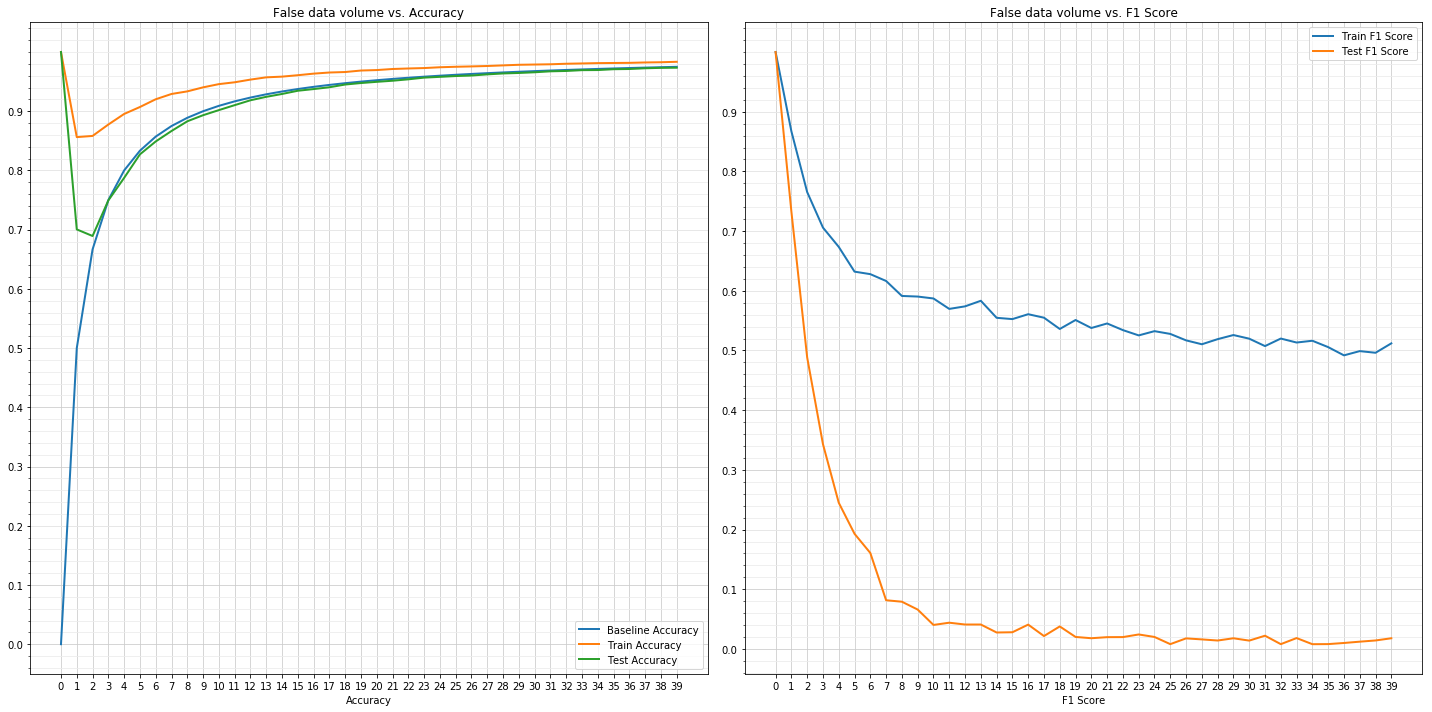

In [9]:
# Train the model for different volumes of false data sets
baseline_accuracy = []
accuracy_train = []
accuracy_test = []
f1_train =[]
f1_test = []

scores = []

x_range = range(0, 40)
for i in x_range:
    scores = fit_and_predict_demolitions(i, 100)

    baseline_accuracy.append(scores[0])
    accuracy_train.append(scores[1])
    accuracy_test.append(scores[2])
    f1_train.append(scores[3])
    f1_test.append(scores[4])
    
measures = [baseline_accuracy, accuracy_train, accuracy_test, f1_train, f1_test]

plot_performance_measures(measures, x_range)


From the above charts, we can see that false_data_volume = 1 provides a wider margin on the model accuracy from the baseline. 

Also, it can be noted that, for the false_data_volume > 2, the baseline accuracy appears to be better than or almost close to our model predictions. It means that our model development is pointless when we chose false_data_volume > 2, we could rather claim none of the buildings are at demolition risk and end up more accurate than letting our model to predict it. 

F1 score is a better performance indicator in the higher ratio zone and in our case it shows a downward trend as the false data volume goes up. This also indicates that our model does not perform well with the highly skewed data set.

With these observations, we conclude that false_data_volume = 1 i.e equal amount of truth and false data is our best option.

Next, let's experiment with the number of estimators on the classifier.

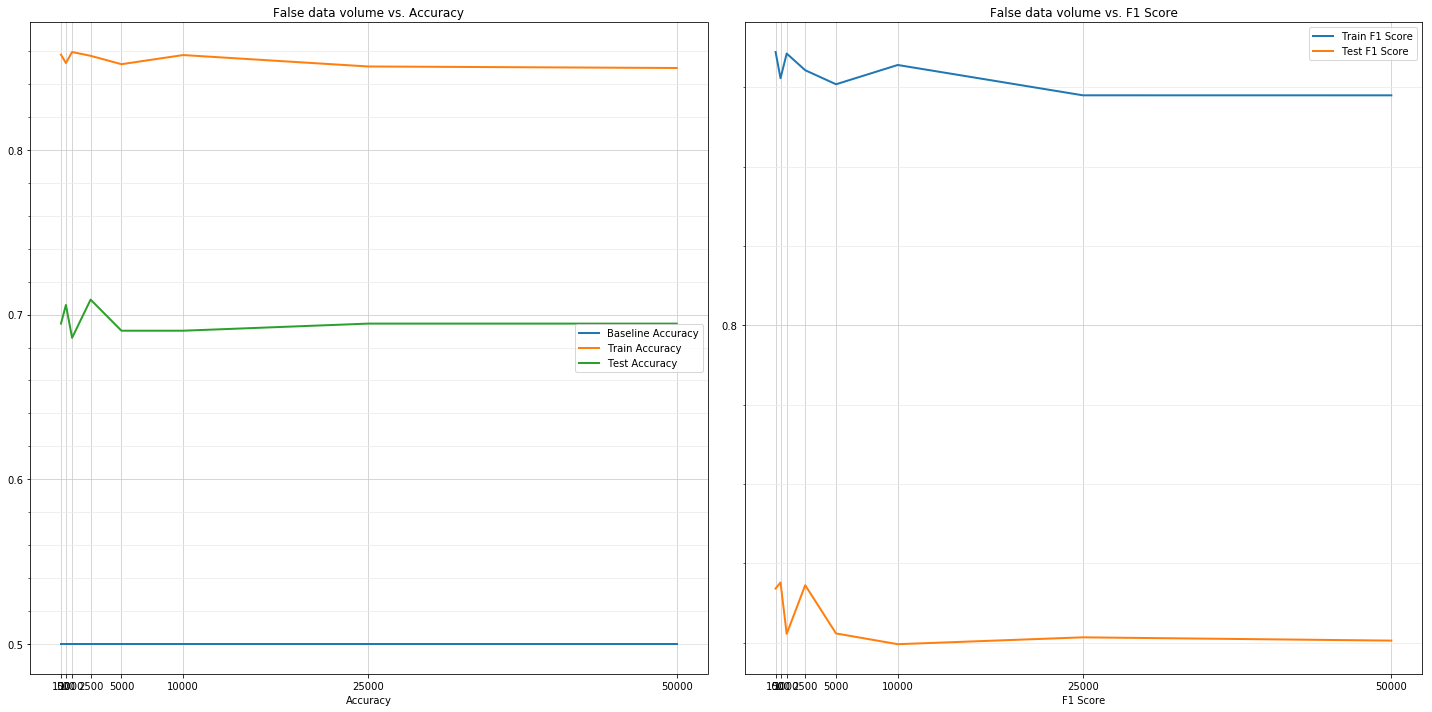

In [10]:
# Train the model for various number of estimators
baseline_accuracy = []
accuracy_train = []
accuracy_test = []
f1_train =[]
f1_test = []

scores = []
x_range = [100, 500, 1000, 2500, 5000, 10000, 25000, 50000]
for i in x_range:
    scores = fit_and_predict_demolitions(1, i)
    
    baseline_accuracy.append(scores[0])
    accuracy_train.append(scores[1])
    accuracy_test.append(scores[2])
    f1_train.append(scores[3])
    f1_test.append(scores[4])

measures = [baseline_accuracy, accuracy_train, accuracy_test, f1_train, f1_test]

plot_performance_measures(measures, x_range)

Repeating the above trials several times, it is observed that our model provides better accuracy when we use around 2500 estimators. 

Let's run the model again with these optimal parameters and observe the accuracies.

In [12]:
scores = fit_and_predict_demolitions(1, 2500)
print 'Baseline Accuracy', scores[0]
print 'Train Accuracy', scores[1]
print 'Test Accuracy', scores[2]

print 'Train F1 Score', scores[3]
print 'Test F1 Score', scores[4]


Baseline Accuracy 0.5
Train Accuracy 0.851894639556
Test Accuracy 0.721443965517
Train F1 Score 0.860561235588
Test F1 Score 0.752038369305


# Summary

In this exercise, we used Detroit city's violation and crime data from different sources to identify the buildings that are at the risk of demolition. 

We started with feature engineering where we cleaned up and standardized the data, for them to be used across all the datasets. We extracted the valuable features from each of these datasets and eventually combined them all into a single features dataset. 

With that, we proceeded to the model development where we used nifty ways to create the training and test datasets. We used Random Forest Classifier as our model in predicting the building's demolition risk. We tuned couple of parameters on this model to further optimize it for the best model accuracy possible. 

With these efforts, we achieved a model that provides a Training accuracy of 0.85 and Test accuracy of 0.72.